In [10]:
!pip3 install pandas --quiet --disable-pip-version-check
import pandas as pd

f = open("sage_with_1s_to.log", "r")
f2 = open("sage_with_60s_to.log", "r")
f3 = open("sage_with_1ms_to.log", "r")

def file_to_dicts(file): 
    file_to_time = {}
    file_to_overhead = {}
    for line in file:
        if "mappings" not in line:
            continue
        splitted = line.split(" ")
        file_to_time[splitted[0]] = float(splitted[10])
        file_to_overhead[splitted[0]] = float(splitted[15]) + float(splitted[20])
    return file_to_time, file_to_overhead

time1s, overhead1s = file_to_dicts(f)
time60s, overhead60s = file_to_dicts(f2)
time1ms, overhead1ms = file_to_dicts(f3)
    
df = pd.DataFrame({'name': time1s.keys(), 'time': time1s.values(), 'overhead': overhead1s.values(),
                   'time 60s': time60s.values(), 'overhead 60s': overhead60s.values(),
                   'time 1ms': time1ms.values(), 'overhead 1ms': overhead1ms.values()})
df.sort_values(by="time 60s", inplace=True)
df.reset_index(inplace=True)

In [11]:
def columnToFloat(df, column):
    if df[column].dtypes != "float64":
        df[column] = df[column].str.replace(',', '.').astype(float)
        
def columnFromMillisToSecond(df, column):
    columnToFloat(df, column)
    df[column] = df[column] / 1000.

# merge the three files in a consistent df with same unit
df_new_sage = pd.read_csv("WatdivBenchmark-Sage force order 1ms-Short.csv")
columnFromMillisToSecond(df_new_sage, "Score")

medium = pd.read_csv("WatdivBenchmark-Sage force order 1ms-Medium.csv")
columnToFloat(medium, "Score")
df_new_sage = pd.concat((df_new_sage, medium), ignore_index=True)

long = pd.read_csv("WatdivBenchmark-Sage force order 1ms-Long.csv")
columnToFloat(long, "Score")
df_new_sage = pd.concat((df_new_sage, long), ignore_index=True)

# so we get the same name of files to join on
df_new_sage['Param: a_query'] = df_new_sage['Param: a_query'].str.replace('sage-jena-benchmarks','')

# effectively merge
df_merged = df.merge(df_new_sage, left_on="name", right_on="Param: a_query", how='left')

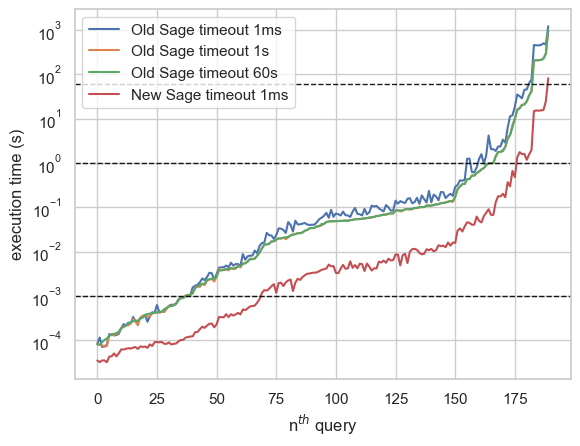

In [14]:
!pip install seaborn --quiet --disable-pip-version-check
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("whitegrid")
# Plot the responses for different events and regions
sns.lineplot(x=df.index, y="time 1ms", data=df, label="Old Sage timeout 1ms")
sns.lineplot(x=df.index, y="time", data=df, label="Old Sage timeout 1s")
graph = sns.lineplot(x=df.index, y="time 60s", data=df, label="Old Sage timeout 60s")
sns.lineplot(x=df.index, y="Score", data=df_merged, label="New Sage timeout 1ms")


plt.yscale('log')
graph.set(xlabel='n$^{th}$ query', ylabel='execution time (s)')

graph.axhline(0.001, linestyle="--", linewidth=1, alpha=0.9, color="black")
graph.axhline(1, linestyle="--", linewidth=1, alpha=0.9, color="black")
graph.axhline(60, linestyle="--", linewidth=1, alpha=0.9, color="black")